# MNIST-Fashion

In [3]:
#benötigte imports
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.eager import context
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import plot_model

2024-05-27 18:41:14.615788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# parallelization Einstellungen
_ = tf.Variable([1])
context._context = None
context._create_context()
num_threads = os.cpu_count()
tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)

In [3]:
# Daten herrunterladen
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [4]:
# Daten laden
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Normalisiere die Daten
x_train = x_train / 255.0
x_test = x_test / 255.0

# Dataset erstellen
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).repeat()  # .repeat() hinzufuegen

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

### Define the model

Standardard convolutional-network mit 3 layers mit drop-out and batch normalization zwischen den Schichten.

In [5]:
# erstellen des Modells
def createModel():
    # Eingabe-layer
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # 1. Hidden-layer
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # 2. Hidden-layer
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # Ausgabe-layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))

    return model

# Training des Modells

In [6]:
# Konfiguration für die Verwendung von CPU oder GPU 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Spezielle GPU-Konfigurationen können hier vorgenommen werden, falls erforderlich
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        strategy = tf.distribute.MirroredStrategy()  # Strategie für mehrere GPUs
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU")
   
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
    
with strategy.scope():
  model = createModel()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
"""
model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=17,
    steps_per_epoch=60,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=17
)
"""
steps_per_epoch = len(x_train) // batch_size
model.fit(
train_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=len(x_test) // batch_size,
    validation_freq=17
)

model.save_weights('.weights.h5', overwrite=True)

No GPU found, using CPU


/Users/moritzschroer/miniconda3/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


2024-05-27 18:41:28.051023: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 763s 402ms/step - loss: 0.9476 - sparse_categorical_accuracy: 0.7187
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 663s 353ms/step - loss: 0.4217 - sparse_categorical_accuracy: 0.8517
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 774s 413ms/step - loss: 0.3699 - sparse_categorical_accuracy: 0.8673
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4433s 2s/step - loss: 0.3422 - sparse_categorical_accuracy: 0.8778
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1066s 569ms/step - loss: 0.3190 - sparse_categorical_accuracy: 0.8843
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11541s 6s/step - loss: 0.3057 - sparse_categorical_accuracy: 0.8923
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4831s 3s/step - loss: 0.2874 - sparse_categorical_accuracy: 0.8986
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 681s 363ms/step - loss: 0.2717 - sparse_categorical_accuracy: 0.9036
Epoch 9/20
1382/1875 ━━━━━━━━━━━━━━━━━━━━ 3:01 368ms/step - loss: 0.2623 - sparse_categorical_accuracy: 0.9062

# Plotten einiger Vorhersagen des trainierten Modells

/Users/moritzschroer/miniconda3/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


/Users/moritzschroer/miniconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


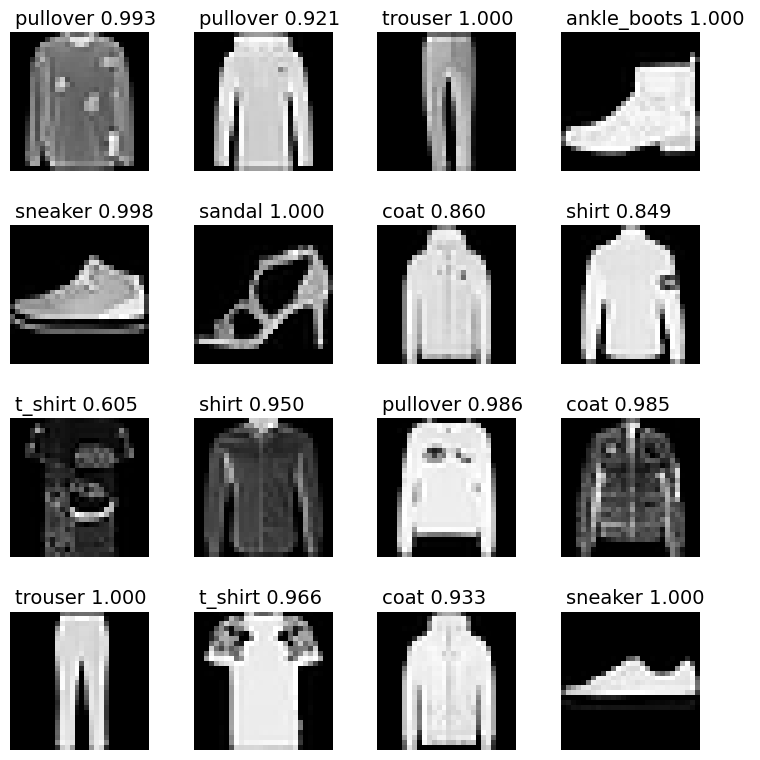

In [23]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

trained_model = createModel()
trained_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
trained_model.load_weights('.weights.h5')

plot_model(trained_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')

    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i], cmap='gray')
    axes[x, y].text(0.5, -2.0, label + ' %.3f ' % confidence, fontsize=14)

  plt.gcf().set_size_inches(8, 8)
  plt.tight_layout(pad=2.0)


x_predict = np.array([x_test[i] for i in random.sample(range(len(x_test)), 16) ]) 

plot_predictions(np.squeeze(x_predict), trained_model.predict(x_predict))

plt.show()